## Install Dependencies and Imports

In [1]:
%pip install pandas scikit-learn matplotlib seaborn textblob nltk python-louvain streamlit python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os
import requests
import json
import time
import math
from requests.exceptions import HTTPError
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from textblob import TextBlob

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import joblib


# Task 1: Data Collection

## Call Twitter API to Retrieve Influencer Profiles and Tweet Data

In [3]:
# Load API keys
load_dotenv()
BASE_URL = "https://twitter241.p.rapidapi.com"
HEADERS = {
    "x-rapidapi-host": "twitter241.p.rapidapi.com",
    "x-rapidapi-key": "4d1e414647msh301eebb9f87ea16p145cf7jsn0ad3b655b133",
}

# Influencer list
INFLUENCER_USERNAMES = [
    "Ninja", "shroud", "Myth_", "DrLupo", "TimTheTatman", "Syndicate", "Summit1g", "Pokimane",
    "Tfue", "Jacksepticeye", "Valkyrae", "Quackity", "TheGrefg", "Jynxzi", "markiplier",
    "SSSniperWolf", "OMGitsAliA", "scump", "LazarBeam", "Pokelawls"
]


# Retry decorator for 429 errors

def retry_on_429():
    def decorator(func):
        def wrapper(*args, **kwargs):
            while True:
                try:
                    return func(*args, **kwargs)
                except HTTPError as e:
                    if e.response.status_code == 429:
                        print(f"⏳ 429 Too Many Requests. Retrying in 0.5s...")
                        time.sleep(0.5)
                        continue
                    else:
                        raise
        return wrapper
    return decorator


# API calls
@retry_on_429()
def get_user_info(username):
    url = f"{BASE_URL}/user"
    params = {"username": username}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

@retry_on_429()
def get_user_followers(user_id, count=100):
    url = f"{BASE_URL}/followers"
    params = {"user": user_id, "count": count}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

@retry_on_429()
def get_user_following(user_id, count=100):
    url = f"{BASE_URL}/followings"
    params = {"user": user_id, "count": count}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

@retry_on_429()
def get_user_tweets(user_id, count=50):
    url = f"{BASE_URL}/user-tweets"
    params = {"user": user_id, "count": count}
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    return response.json()

# Output folders
os.makedirs("data/raw/profiles", exist_ok=True)
os.makedirs("data/raw/followers", exist_ok=True)
os.makedirs("data/raw/following", exist_ok=True)
os.makedirs("data/raw/tweets", exist_ok=True)

# Collect data
for username in INFLUENCER_USERNAMES:
    print(f"\n📦 Collecting data for {username}...")

    user_info = get_user_info(username)
    if not user_info:
        print(f"⚠️ Failed to fetch user info for {username}")
        continue

    # Extract user ID from nested structure
    user_data = user_info.get("result", {}).get("data", {}).get("user", {}).get("result", {})
    user_id = user_data.get("rest_id")

    if not user_id:
        print(f"❌ User ID not found for {username}")
        continue

    # Save profile
    with open(f"data/raw/profiles/{username}.json", "w") as f:
        json.dump(user_info, f, indent=2)
    print(f"✅ Profile saved for {username}")

    # Get and save tweets
    tweets = get_user_tweets(user_id)
    if tweets:
        with open(f"data/raw/tweets/{username}.json", "w") as f:
            json.dump([{"tweets": tweets}], f, indent=2)
        print(f"✅ Tweets saved for {username}")

    # Get and save followers
    followers = get_user_followers(user_id)
    if followers:
        with open(f"data/raw/followers/{username}.json", "w") as f:
            json.dump(followers, f, indent=2)
        print(f"✅ Followers saved for {username}")

    # Get and save following
    following = get_user_following(user_id)
    if following:
        with open(f"data/raw/following/{username}.json", "w") as f:
            json.dump(following, f, indent=2)
        print(f"✅ Following saved for {username}")

    # Delay to reduce risk of rate limits

print("\n🎉 All data collected and saved per influencer.")


📦 Collecting data for Ninja...
✅ Profile saved for Ninja
⏳ 429 Too Many Requests. Retrying in 0.5s...
✅ Tweets saved for Ninja
✅ Followers saved for Ninja
✅ Following saved for Ninja

📦 Collecting data for shroud...
✅ Profile saved for shroud
⏳ 429 Too Many Requests. Retrying in 0.5s...
✅ Tweets saved for shroud
✅ Followers saved for shroud
✅ Following saved for shroud

📦 Collecting data for Myth_...
✅ Profile saved for Myth_
⏳ 429 Too Many Requests. Retrying in 0.5s...
✅ Tweets saved for Myth_
✅ Followers saved for Myth_
✅ Following saved for Myth_

📦 Collecting data for DrLupo...
✅ Profile saved for DrLupo
✅ Tweets saved for DrLupo
✅ Followers saved for DrLupo
✅ Following saved for DrLupo

📦 Collecting data for TimTheTatman...
✅ Profile saved for TimTheTatman
⏳ 429 Too Many Requests. Retrying in 0.5s...
✅ Tweets saved for TimTheTatman
✅ Followers saved for TimTheTatman
✅ Following saved for TimTheTatman

📦 Collecting data for Syndicate...
✅ Profile saved for Syndicate
✅ Tweets saved

## Load Tweet Data

In [4]:
tweet_folder = "data/raw/tweets/"

def load_tweet_data(tweet_folder):
    records = []
    for filename in os.listdir(tweet_folder):
        if not filename.endswith(".json"):
            continue
        username = filename.replace(".json", "")
        with open(os.path.join(tweet_folder, filename), 'r') as f:
            data = json.load(f)
            instructions = data[0].get("tweets", {}).get("result", {}).get("timeline", {}).get("instructions", [])
            for instruction in instructions:
                if "entries" not in instruction:
                    continue
                for entry in instruction["entries"]:
                    tweet = (
                        entry.get("content", {})
                             .get("itemContent", {})
                             .get("tweet_results", {})
                             .get("result", {})
                    )
                    legacy = tweet.get("legacy", {})
                    if not legacy:
                        continue
                    mentions = []
                    entities = legacy.get("entities", {})
                    if "user_mentions" in entities:
                        mentions = [m.get("screen_name", "") for m in entities["user_mentions"]]
                    in_reply_to = legacy.get("in_reply_to_screen_name", None)
                    records.append({
                        "username": username,
                        "created_at": legacy.get("created_at"),
                        "retweet_count": legacy.get("retweet_count", 0),
                        "reply_count": legacy.get("reply_count", 0),
                        "like_count": legacy.get("favorite_count", 0),
                        "quote_count": legacy.get("quote_count", 0),
                        "text": legacy.get("full_text", ""),
                        "mentions": mentions,
                        "in_reply_to": in_reply_to
                    })
    return pd.DataFrame(records)

## Data Preprocessing and Aggregation

In [5]:
def preprocess(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['week'] = df['created_at'].dt.to_period("W").astype(str)
    df['text_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    df['total_engagement'] = df['like_count'] + df['retweet_count'] + df['reply_count'] + df['quote_count']
    return df

In [6]:
def aggregate_weekly(df):
    grouped = df.groupby(["username", "week"]).agg({
        "total_engagement": "mean",
        "text_length": "mean",
        "retweet_count": "mean",
        "reply_count": "mean",
        "like_count": "mean",
        "quote_count": "mean",
        "text": "count"
    }).rename(columns={"text": "tweet_count"}).reset_index()
    return grouped

# Task 2: Social Network Construction

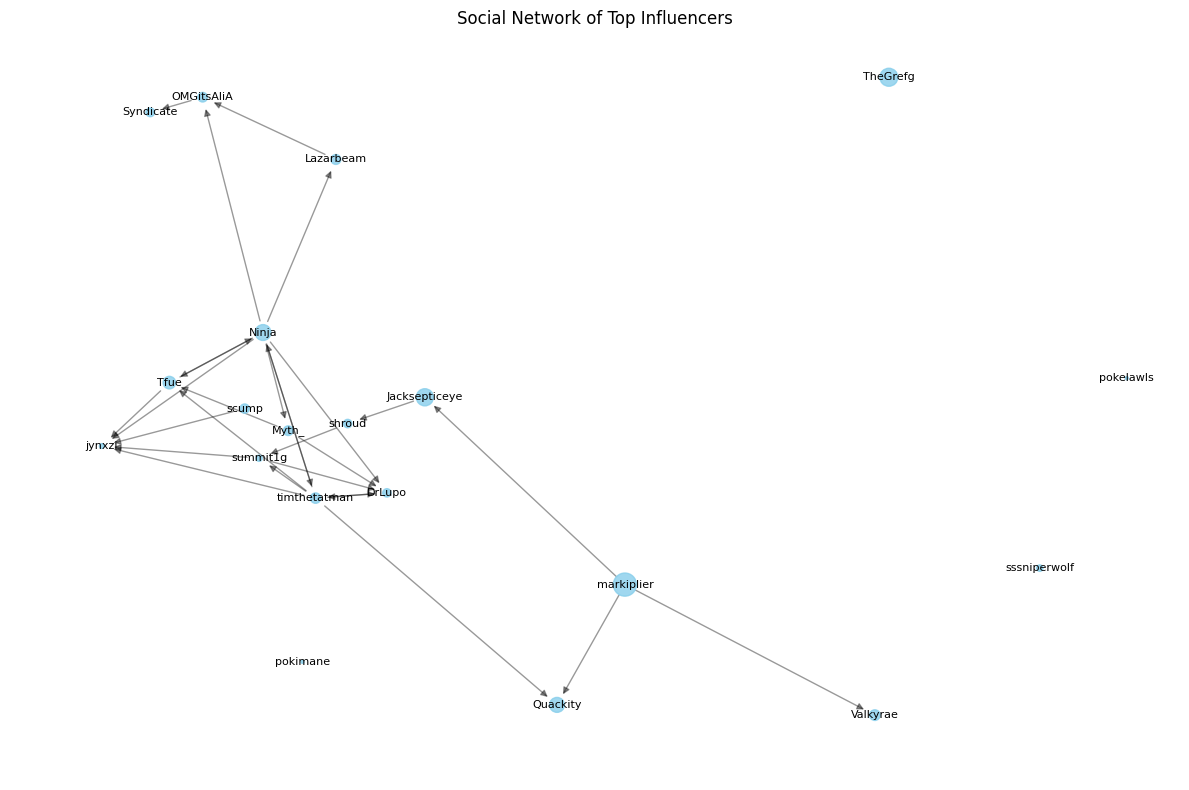

Network Statistics:
Number of nodes: 20
Number of edges: 28
Network density: 0.0737

Influencer Summary:
                name    screen_name  followers_count
14              Mark     markiplier         13865741
12          Grefg =)       TheGrefg          8387320
9      Jacksepticeye  Jacksepticeye          7627231
0              Ninja          Ninja          6528161
11          Quackity       Quackity          5780664
8               Tfue           Tfue          4066596
10               RAE       Valkyrae          2944525
4      timthetatman👑   timthetatman          2817583
18             LAZAR      Lazarbeam          2540244
2               Myth          Myth_          2404818
16             Ali-A     OMGitsAliA          2383888
17       OpTic Scump          scump          2240844
5                Tom      Syndicate          1958706
1   Michael Grzesiek         shroud          1844237
3             DrLupo         DrLupo          1815186
15               Lia   sssniperwolf          10

In [7]:
# Task 2: Social Network Construction
import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd

# Load the collected data
with open('data/raw/influencer_profiles.json', 'r') as f:
    influencer_profiles = json.load(f)

with open('data/raw/following_data.json', 'r') as f:
    following_data = json.load(f)

# Create a directed graph
G = nx.DiGraph()

# Store influencer nodes with their metadata
influencer_nodes = []
user_id_map = {}  # screen_name.lower() → user_id
screen_name_map = {}  # user_id → screen_name.lower()

# Add influencer nodes to graph
for profile in influencer_profiles:
    try:
        user_data = profile['result']['data']['user']['result']
        user_id = user_data['rest_id']
        screen_name = user_data['legacy']['screen_name']
        name = user_data['legacy']['name']
        followers_count = user_data['legacy']['followers_count']
        friends_count = user_data['legacy']['friends_count']
        statuses_count = user_data['legacy']['statuses_count']

        G.add_node(user_id,
                   screen_name=screen_name,
                   name=name,
                   followers_count=followers_count,
                   friends_count=friends_count,
                   statuses_count=statuses_count,
                   is_influencer=True)

        influencer_nodes.append({
            'user_id': user_id,
            'screen_name': screen_name,
            'name': name,
            'followers_count': followers_count,
            'friends_count': friends_count,
            'statuses_count': statuses_count
        })

        user_id_map[screen_name.lower()] = user_id
        screen_name_map[user_id] = screen_name.lower()

    except (KeyError, TypeError) as e:
        print(f"Error processing profile: {e}")

# Convert to DataFrame for analysis
influencer_df = pd.DataFrame(influencer_nodes)

# Extract real following relationships to build edges
def extract_following_ids(entries):
    user_ids = set()
    for entry in entries:
        try:
            content = entry['content']['itemContent']
            followed_id = content['user_results']['result']['rest_id']
            user_ids.add(followed_id)
        except (KeyError, TypeError):
            continue
    return user_ids

# Create edges: source → target if source follows target and both are influencers
influencer_ids = set(screen_name_map.keys())

for item in following_data:
    source_id = item['user_id']
    instructions = item.get('following', {}).get('result', {}).get('timeline', {}).get('instructions', [])

    # Find the 'TimelineAddEntries' section with actual data
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            followed_ids = extract_following_ids(entries)

            for target_id in followed_ids:
                if target_id in influencer_ids:
                    G.add_edge(source_id, target_id, weight=1)

# Visualize the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes
node_sizes = [G.nodes[n]['followers_count'] / 1_000_000 for n in G.nodes()]
nx.draw_networkx_nodes(G, pos,
                       node_size=[max(5, size * 20) for size in node_sizes],
                       node_color='skyblue',
                       alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Draw labels
labels = {node: G.nodes[node]['screen_name'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Social Network of Top Influencers")
plt.axis('off')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/influencer_network.png', dpi=300)
plt.show()
plt.close()

# Save the graph
nx.write_gexf(G, 'data/processed/influencer_network.gexf')

# Display stats
print("Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Display influencer info
print("\nInfluencer Summary:")
print(influencer_df[['name', 'screen_name', 'followers_count']].sort_values(by='followers_count', ascending=False))

print("\nSocial network construction (real data) completed!")


# Task 3: Social Network Analysis

Community detection based on network structure (Louvain) completed.


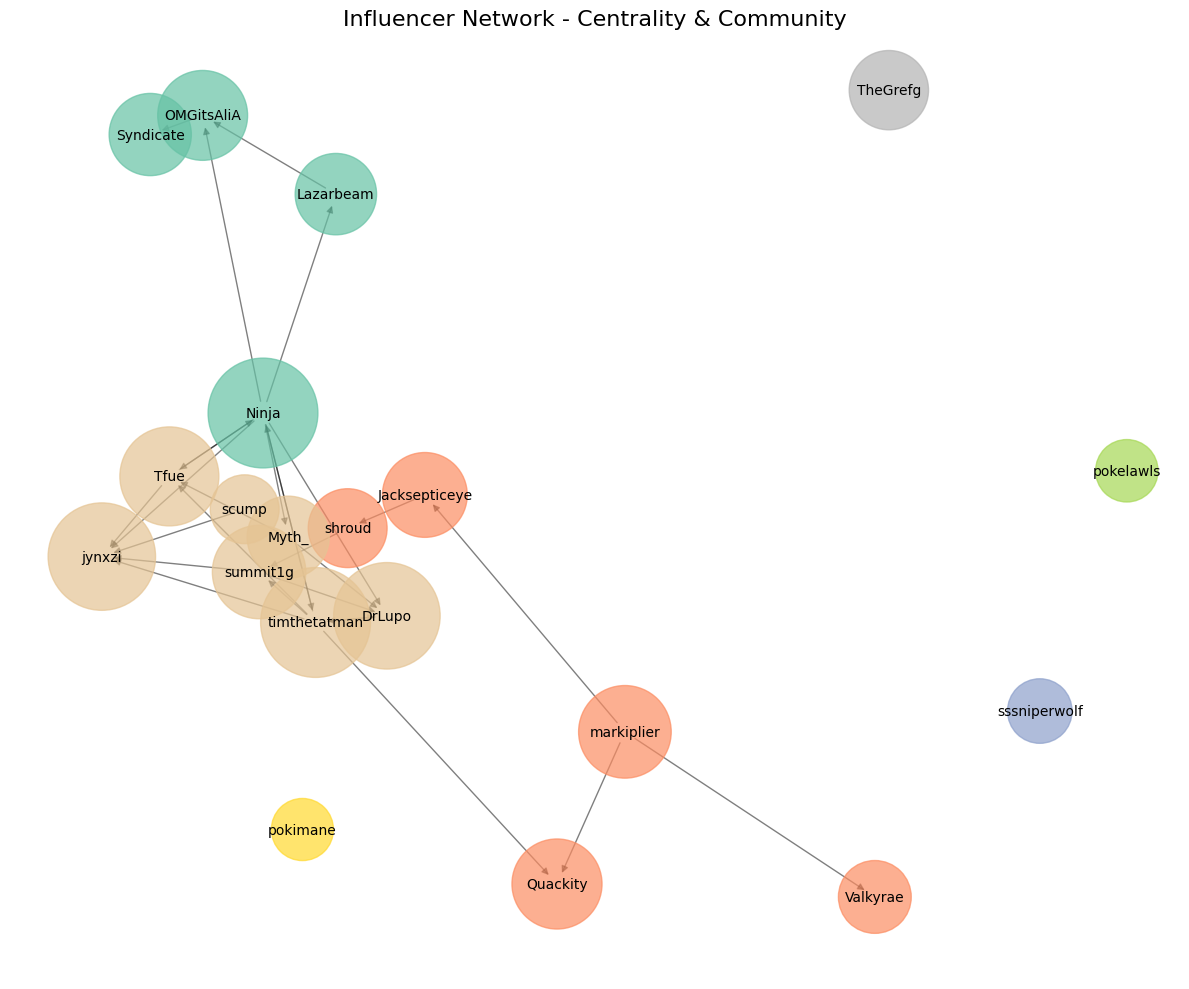

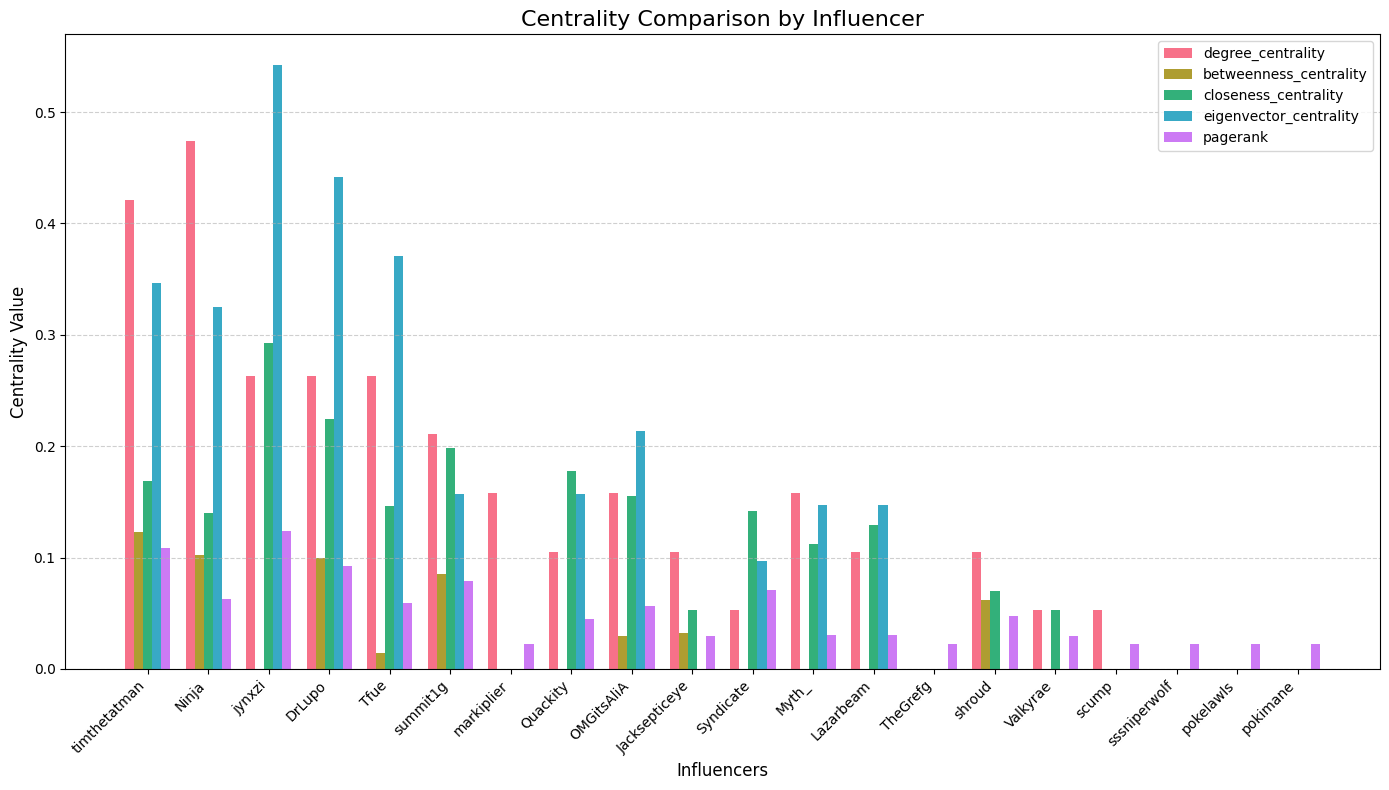

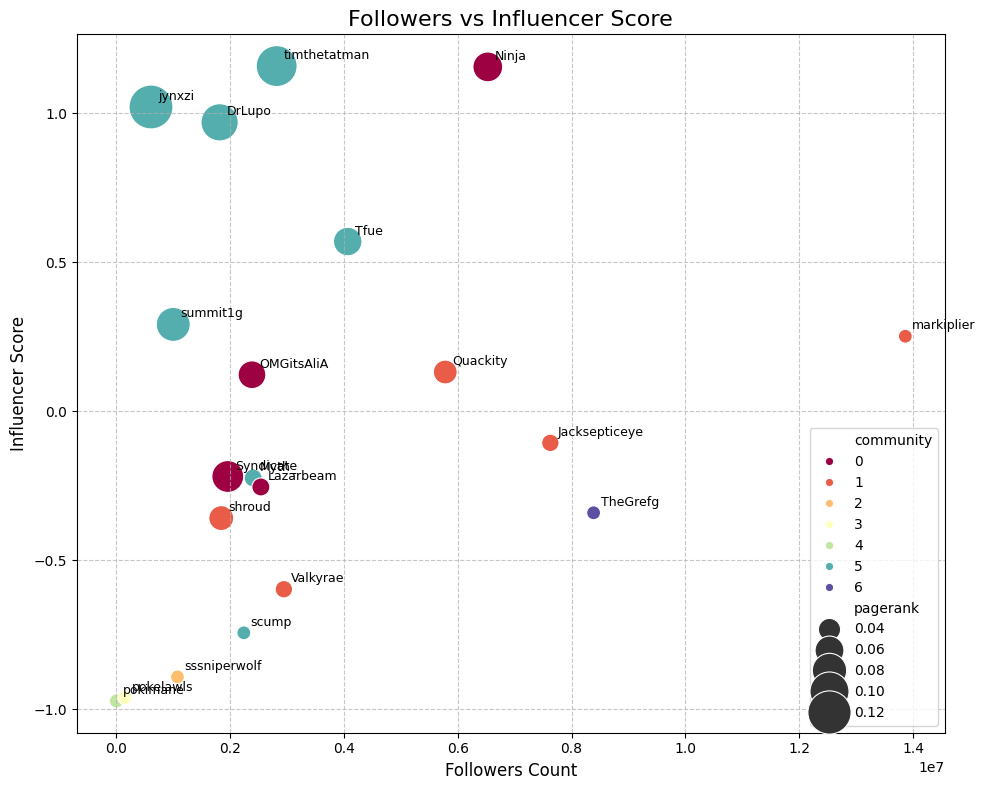

Top 5 Influencers Based on Composite Score:
             name   screen_name  followers_count  influencer_score
4   timthetatman👑  timthetatman        2817583.0          1.157466
0           Ninja         Ninja        6528161.0          1.154808
13         Jynxzi        jynxzi         609082.0          1.020255
3          DrLupo        DrLupo        1815186.0          0.968799
8            Tfue          Tfue        4066596.0          0.569018

Social network analysis completed!

Top influencers in each community based on influencer score:

Community 0:
   screen_name  followers_count  influencer_score
0        Ninja        6528161.0          1.154808
16  OMGitsAliA        2383888.0          0.122382
5    Syndicate        1958706.0         -0.218962

Community 1:
      screen_name  followers_count  influencer_score
14     markiplier       13865741.0          0.251415
11       Quackity        5780664.0          0.131434
9   Jacksepticeye        7627231.0         -0.106235

Community 2:
  

In [8]:
# Task 3: Social Network Analysis
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the influencer network graph
G = nx.read_gexf('data/processed/influencer_network.gexf')

# === 1. CENTRALITY ANALYSIS ===
# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)

# Combine into DataFrame
centrality_df = pd.DataFrame({
    'user_id': list(G.nodes()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'eigenvector_centrality': list(eigenvector_centrality.values()),
    'pagerank': list(pagerank.values())
})

# Add influencer attributes from the graph
for i, node in enumerate(centrality_df['user_id']):
    centrality_df.loc[i, 'name'] = G.nodes[node]['name']
    centrality_df.loc[i, 'screen_name'] = G.nodes[node]['screen_name']
    centrality_df.loc[i, 'followers_count'] = float(G.nodes[node]['followers_count'])
    centrality_df.loc[i, 'friends_count'] = float(G.nodes[node]['friends_count'])
    centrality_df.loc[i, 'statuses_count'] = float(G.nodes[node]['statuses_count'])

# === 2. INFLUENCER SCORE ===
# Normalize centrality + followers data
scaler = StandardScaler()
features = ['degree_centrality', 'betweenness_centrality', 
            'closeness_centrality', 'eigenvector_centrality', 
            'pagerank', 'followers_count']
scaled_centrality = scaler.fit_transform(centrality_df[features])

# Weighted score
weights = [0.15, 0.10, 0.10, 0.25, 0.15, 0.25]
influencer_scores = np.dot(scaled_centrality, np.array(weights))
centrality_df['influencer_score'] = influencer_scores

# === 3. COMMUNITY DETECTION BASED ON GRAPH STRUCTURE ===
try:
    import community as community_louvain  # Make sure you have 'python-louvain' installed
except ImportError:
    raise ImportError("Please install it via pip: pip install python-louvain")

# Convert to undirected for better community detection
G_undirected = G.to_undirected()

# Run Louvain algorithm on the graph (structure-based)
partition = community_louvain.best_partition(G_undirected, resolution=1.0)

# Map communities back to the DataFrame
centrality_df['community'] = centrality_df['user_id'].map(partition)

# Assign community as node attribute in graph
nx.set_node_attributes(G, partition, 'community')

print("Community detection based on network structure (Louvain) completed.")


# === 4. ANALYSIS OUTPUT ===
# Save centrality metrics and scores
centrality_df.to_csv('data/outputs/centrality/influencer_centrality.csv', index=False)

# === 5. VISUALIZATIONS ===
# Network with influencer score + community
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
node_sizes = [(score + abs(min(influencer_scores)) + 1) * 2000 for score in influencer_scores]
node_colors = [centrality_df.loc[centrality_df['user_id'] == node, 'community'].values[0] for node in G.nodes()]


nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7, cmap=plt.cm.Set2)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={node: centrality_df.loc[centrality_df['user_id'] == node, 'screen_name'].values[0] for node in G.nodes()}, font_size=10)
plt.title("Influencer Network - Centrality & Community", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/influencer_analysis_network.png', dpi=300)
plt.show()
plt.close()

# Centrality bar comparison
plt.figure(figsize=(14, 8))
measure_cols = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
colors = sns.color_palette("husl", len(measure_cols))
sorted_df = centrality_df.sort_values('influencer_score', ascending=False)
x = np.arange(len(sorted_df))
width = 0.15

for i, column in enumerate(measure_cols):
    plt.bar(x + i*width, sorted_df[column], width, label=column, color=colors[i])

plt.xlabel('Influencers', fontsize=12)
plt.ylabel('Centrality Value', fontsize=12)
plt.title('Centrality Comparison by Influencer', fontsize=16)
plt.xticks(x + width*2, sorted_df['screen_name'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('data/outputs/visualizations/centrality_comparison.png', dpi=300)
plt.show()
plt.close()

# Followers vs Influencer Score
plt.figure(figsize=(10, 8))
sns.scatterplot(x='followers_count', y='influencer_score',
                hue='community', size='pagerank', sizes=(100, 1000),
                data=centrality_df, palette='Spectral')

for i, row in centrality_df.iterrows():
    plt.annotate(row['screen_name'], (row['followers_count'], row['influencer_score']),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title("Followers vs Influencer Score", fontsize=16)
plt.xlabel("Followers Count", fontsize=12)
plt.ylabel("Influencer Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('data/outputs/visualizations/followers_vs_score.png', dpi=300)
plt.show()
plt.close()

# === 6. OUTPUT TOP INFLUENCERS AND COMMUNITY STATS ===
print("Top 5 Influencers Based on Composite Score:")
print(centrality_df[['name', 'screen_name', 'followers_count', 'influencer_score']].sort_values(by='influencer_score', ascending=False).head(5))

# print("\nCommunity Group Summary (mean influencer score per group):")
# print(centrality_df.groupby('community')['influencer_score'].mean().reset_index().sort_values(by='influencer_score', ascending=False))

print("\nSocial network analysis completed!")

print("\nTop influencers in each community based on influencer score:")
for comm_id in sorted(centrality_df['community'].unique()):
    print(f"\nCommunity {comm_id}:")
    top_group = centrality_df[centrality_df['community'] == comm_id].sort_values("influencer_score", ascending=False).head(3)
    print(top_group[['screen_name', 'followers_count', 'influencer_score']])
    
num_communities = len(set(partition.values()))
print(f"\nTotal communities detected: {num_communities}")




# Task 4: Influence Prediction with AI

## Data Preparation for Model Training

In [9]:
def add_rolling_features(df_weekly, window=3):
    df_weekly = df_weekly.sort_values(["username", "week"]).copy()
    df_weekly["rolling_engagement"] = (
        df_weekly.groupby("username")["total_engagement"]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    df_weekly["rolling_tweet_count"] = (
        df_weekly.groupby("username")["tweet_count"]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    df_weekly["engagement_per_text_length"] = df_weekly["total_engagement"] / df_weekly["text_length"].replace(0, 1)
    df_weekly["tweet_count_delta"] = (
        df_weekly.groupby("username")["tweet_count"]
        .diff().fillna(0)
    )
    return df_weekly


## Feature Engineering

✅ Loaded 306 tweets.


/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_27823/2602625136.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_27823/2602625136.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['created_at'].dt.to_period("W").astype(str)


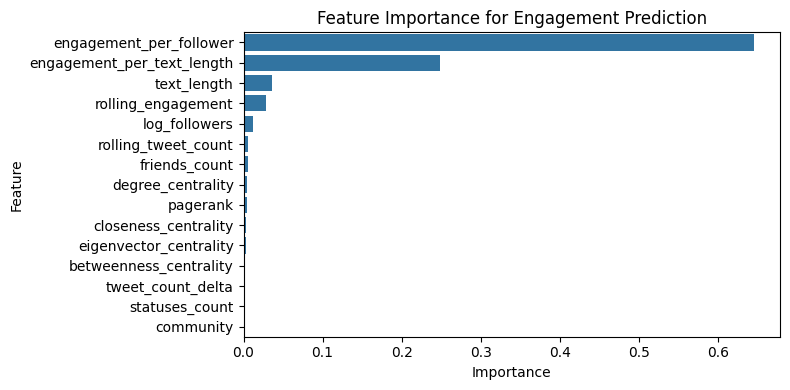

In [10]:
# Step 1: Load + preprocess raw tweet data
raw_df = load_tweet_data(tweet_folder)
print(f"✅ Loaded {len(raw_df)} tweets.")
raw_df = preprocess(raw_df)

# Step 2: Aggregate to weekly
weekly_df = aggregate_weekly(raw_df)

# Step 4: Add rolling features
weekly_df = add_rolling_features(weekly_df)

centrality_df = pd.read_csv('data/outputs/centrality/influencer_centrality.csv')

# Merge into weekly_df on username/screen_name
# Add more centrality metrics
weekly_df = weekly_df.merge(
    centrality_df[['screen_name', 'degree_centrality', 'pagerank', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality',
                   'followers_count', 'friends_count', 'statuses_count', 'community']],
    how='left',
    left_on='username',
    right_on='screen_name'
)

# Encode community as categorical number (if not already)
weekly_df['community'] = weekly_df['community'].astype('category').cat.codes

# Optionally create new features
weekly_df['log_followers'] = np.log1p(weekly_df['followers_count'])
weekly_df['engagement_per_follower'] = weekly_df['total_engagement'] / weekly_df['followers_count'].replace(0, 1)

# Optional: drop the redundant screen_name column after merge
weekly_df.drop(columns=['screen_name'], inplace=True)

# Now proceed with your feature definition and model training

feature_cols = [
    "text_length",
    "degree_centrality",
    "betweenness_centrality",
    "closeness_centrality",
    "eigenvector_centrality",
    "pagerank",
    "log_followers",
    "friends_count",
    "statuses_count",
    "community",
    "rolling_engagement",
    "rolling_tweet_count",
    "engagement_per_text_length",
    "engagement_per_follower",
    "tweet_count_delta"
]

# Step 6: Prepare training data
df_model = weekly_df.dropna(subset=feature_cols + ["total_engagement"])
X = df_model[feature_cols]
y = df_model["total_engagement"]


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feat_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

# === Plot ===
plt.figure(figsize=(8, 4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance for Engagement Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/feature_importance_engagement.png", dpi=300)
plt.show()

## Model Training and Prediction

In [11]:
def predict_and_plot_all_influencers(data, test_weeks=4):
    
    os.makedirs("data/outputs/visualizations", exist_ok=True)

    # Filter influencers with enough data first
    influencers = []
    for influencer in data["username"].unique():
        df = data[data["username"] == influencer]
        if len(df) >= test_weeks + 3:
            influencers.append(influencer)

    n = len(influencers)
    if n == 0:
        print("No influencers with enough data to plot.")
        return

    cols = 2  # Adjust columns as needed
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), squeeze=False)

    for i, influencer in enumerate(influencers):
        df = data[data["username"] == influencer].sort_values("week").copy()
        df["week_num"] = range(len(df))

        X = df[["week_num"]]
        y = df["total_engagement"]

        X_train, y_train = X[:-test_weeks], y[:-test_weeks]
        X_test, y_test = X[-test_weeks:], y[-test_weeks:]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ax = axes[i // cols][i % cols]
        ax.plot(df["week"], y, label="Actual", marker='o')
        ax.plot(df["week"].iloc[-test_weeks:], y_pred, label="Predicted", marker='x')
        ax.set_title(f"{influencer}")
        ax.set_xlabel("Week")
        ax.set_ylabel("Engagement")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend()

        print(f"🔍 MAE for {influencer}: {mean_absolute_error(y_test, y_pred):.2f}")

    # Remove unused axes if any
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols][j % cols])

    plt.tight_layout()

    output_path = "data/outputs/visualizations/combined_influencer_predictions.png"
    plt.savefig(output_path, dpi=300)

    plt.show()
    print(f"✅ Saved combined figure to: {output_path}")

🔍 MAE for DrLupo: 8092.44
🔍 MAE for Jacksepticeye: 23998.05
🔍 MAE for Jynxzi: 7927.04
🔍 MAE for LazarBeam: 24194.03
🔍 MAE for Ninja: 21228.67
🔍 MAE for Pokelawls: 355.05
🔍 MAE for Quackity: 41561.91
🔍 MAE for Tfue: 9929.25
🔍 MAE for markiplier: 111520.80


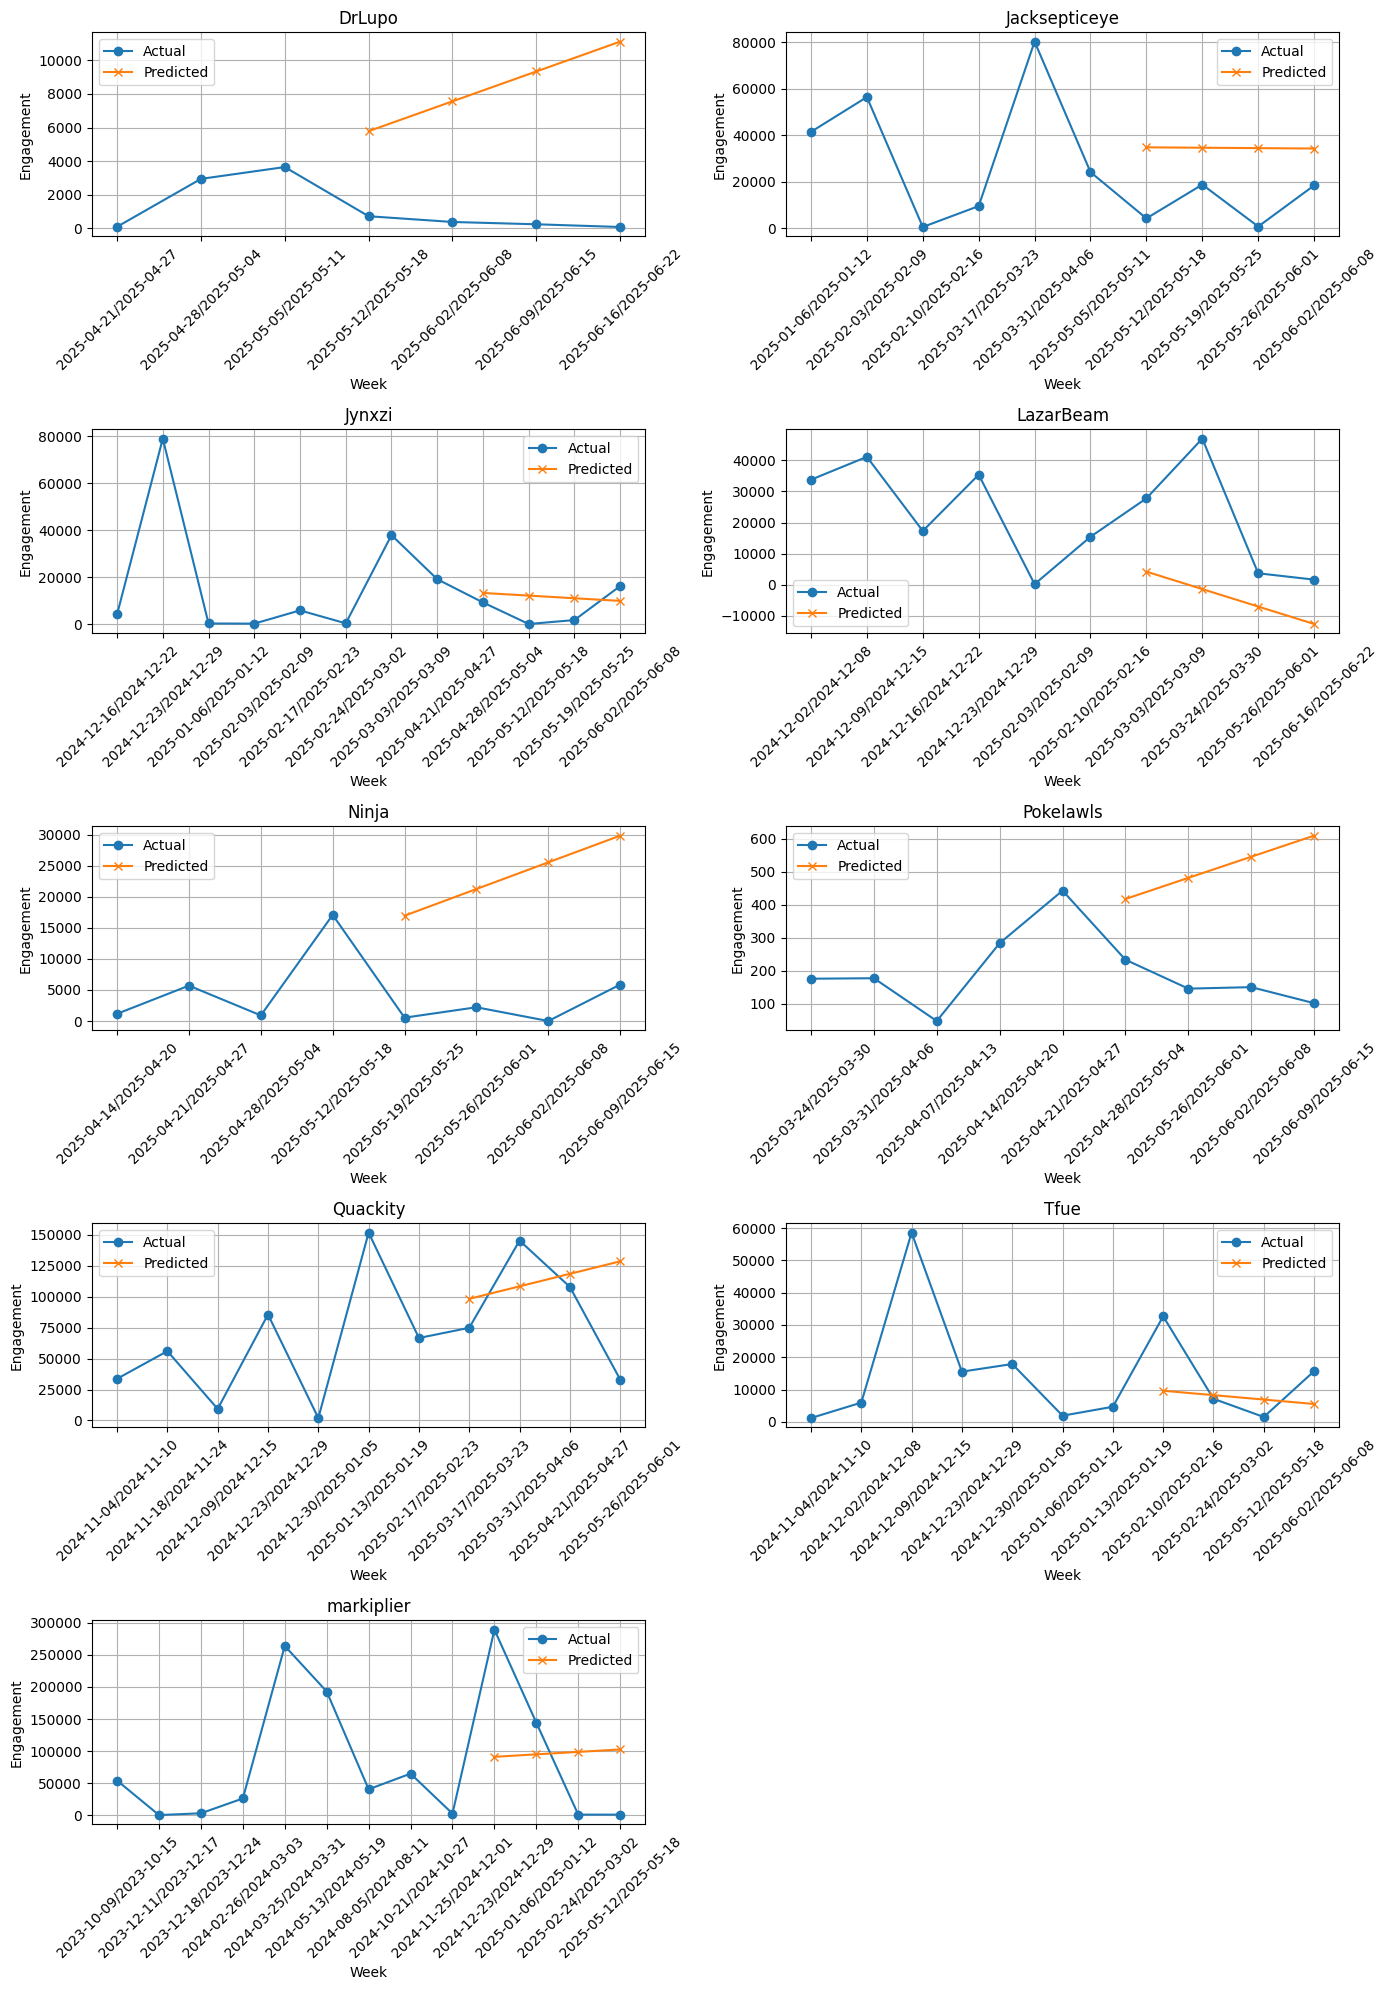

✅ Saved combined figure to: data/outputs/visualizations/combined_influencer_predictions.png


In [12]:
# Run predictions for all influencers
predict_and_plot_all_influencers(weekly_df)

## Performance Analysis

### Average Engagement Rate by Day of Week

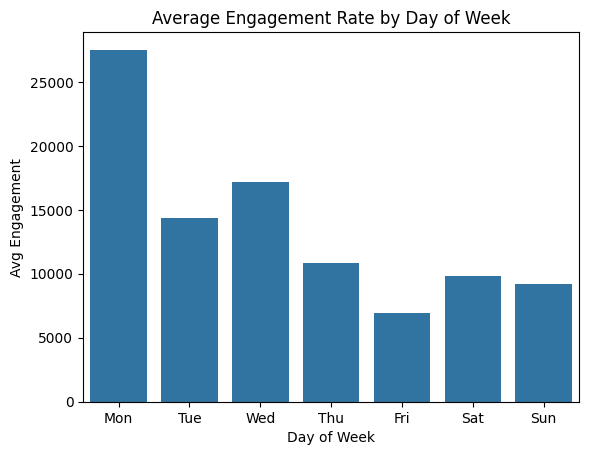

In [13]:
# Use raw_df which contains created_at at tweet level
raw_df['day_of_week'] = raw_df['created_at'].dt.dayofweek

engagement_by_day = raw_df.groupby('day_of_week')['total_engagement'].mean().reset_index()
engagement_by_day['day_name'] = engagement_by_day['day_of_week'].map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

sns.barplot(x='day_name', y='total_engagement', data=engagement_by_day)
plt.title("Average Engagement Rate by Day of Week")
plt.ylabel("Avg Engagement")
plt.xlabel("Day of Week")
plt.savefig("data/outputs/visualizations/avg_engagement_by_day.png", dpi=300)
plt.show()




## Strategy Recommendations

### Optimal Posting Tweets Hours For Each Influencers

          username  day_of_week  hour  total_engagement
10          DrLupo            4    10           17393.0
17   Jacksepticeye            0    13          246143.0
37          Jynxzi            1    20           78958.0
54       LazarBeam            3    11           65126.0
70           Myth_            5    18            4077.0
74           Ninja            1    14           20662.0
93      OMGitsAliA            3    14            3553.0
109      Pokelawls            0    19             849.0
123       Quackity            0     0          151586.0
138   SSSniperWolf            2    22           22647.0
151       Summit1g            4    19             280.0
168      Syndicate            5    23            5816.0
180           Tfue            3    20           58570.0
193       TheGrefg            4    14           19874.0
216   TimTheTatman            4    19            5332.0
222       Valkyrae            0    20           57185.0
231     markiplier            0     1          2

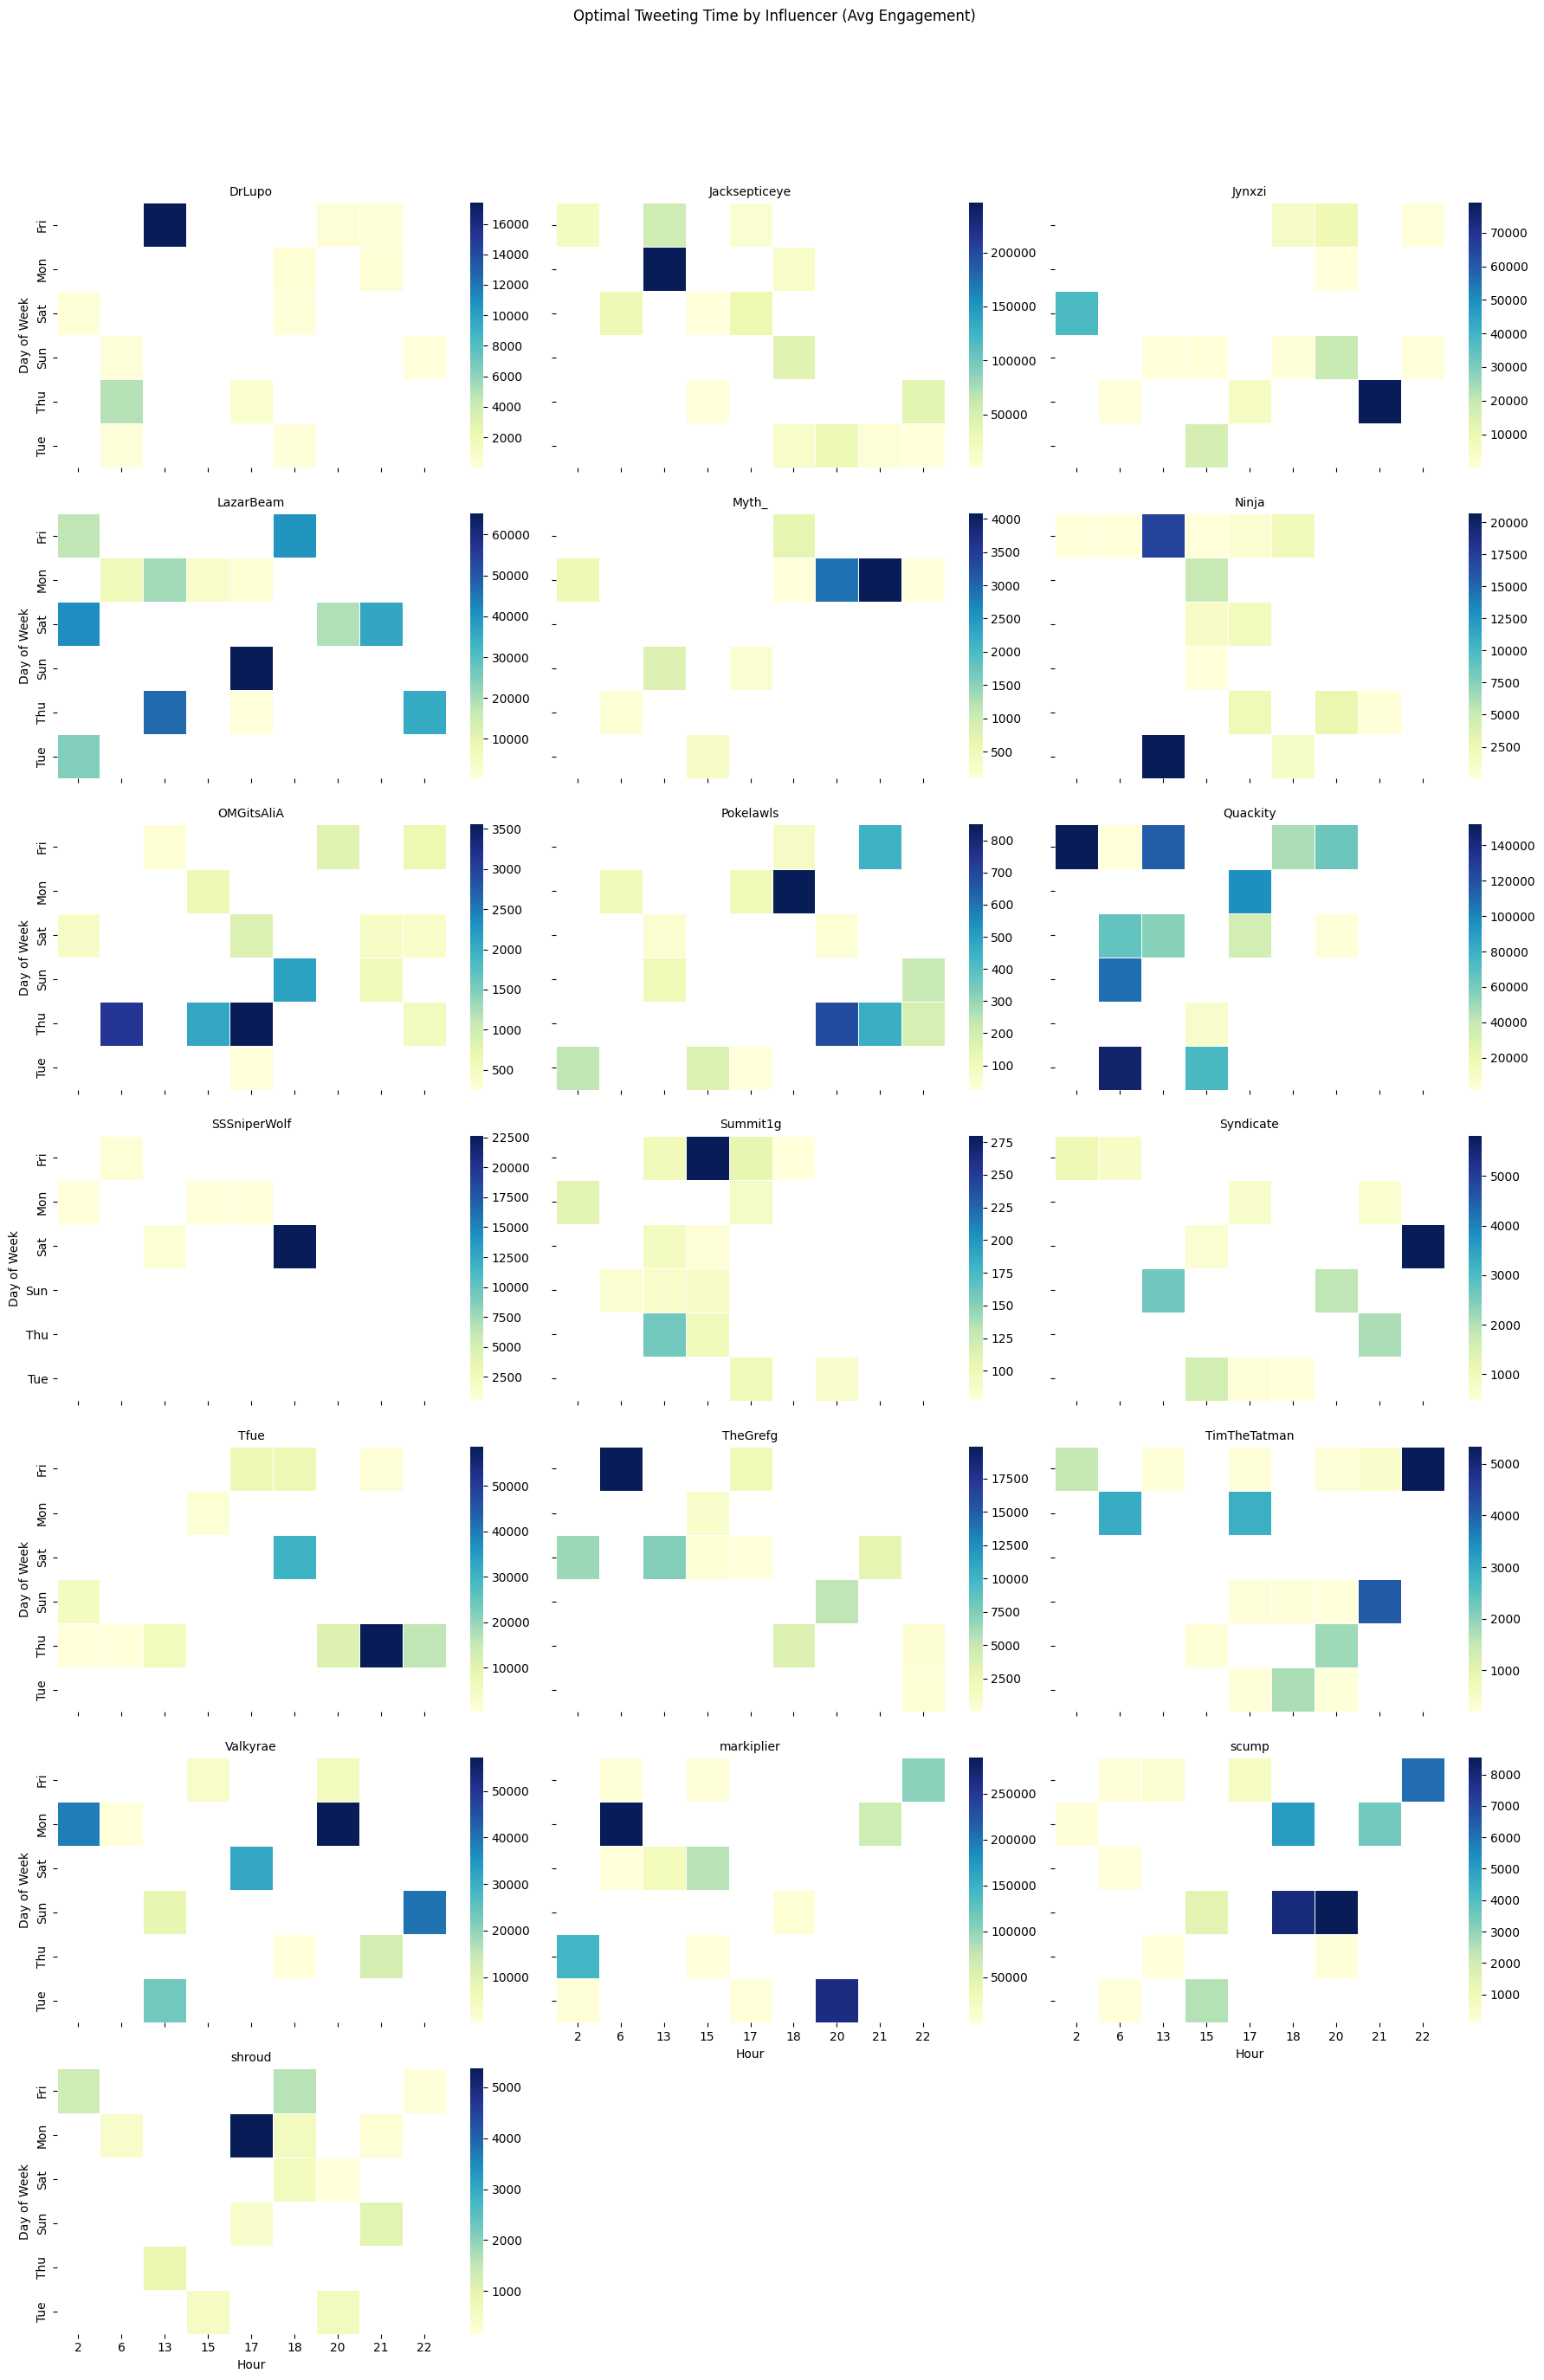

In [14]:
raw_df['hour'] = raw_df['created_at'].dt.hour

# Group by influencer, day, hour, avg engagement
best_times = raw_df.groupby(['username', 'day_of_week', 'hour'])['total_engagement'].mean().reset_index()

# For each influencer, find the day-hour with highest avg engagement
optimal_times = best_times.loc[best_times.groupby('username')['total_engagement'].idxmax()]

print(optimal_times[['username', 'day_of_week', 'hour', 'total_engagement']])

import seaborn as sns
import matplotlib.pyplot as plt

# Map day_of_week integers to names
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
best_times['day_name'] = best_times['day_of_week'].map(day_map)

# Pivot the data for heatmap (optional: top influencers only)
top_influencers = best_times['username'].value_counts().nlargest(20).index  # adjust number of influencers
filtered = best_times[best_times['username'].isin(top_influencers)]

# Plot heatmaps per influencer
g = sns.FacetGrid(filtered, col='username', col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(
    lambda data, color: sns.heatmap(
        data.pivot(index='day_name', columns='hour', values='total_engagement'),
        cmap="YlGnBu", cbar=True, linewidths=.5
    )
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Hour", "Day of Week")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Optimal Tweeting Time by Influencer (Avg Engagement)")
g.savefig("data/outputs/visualizations/optimal_tweeting_time_by_influencer.png", dpi=300)

plt.show()



### Day of Week Vs Engagement Rate Correlation Distribution

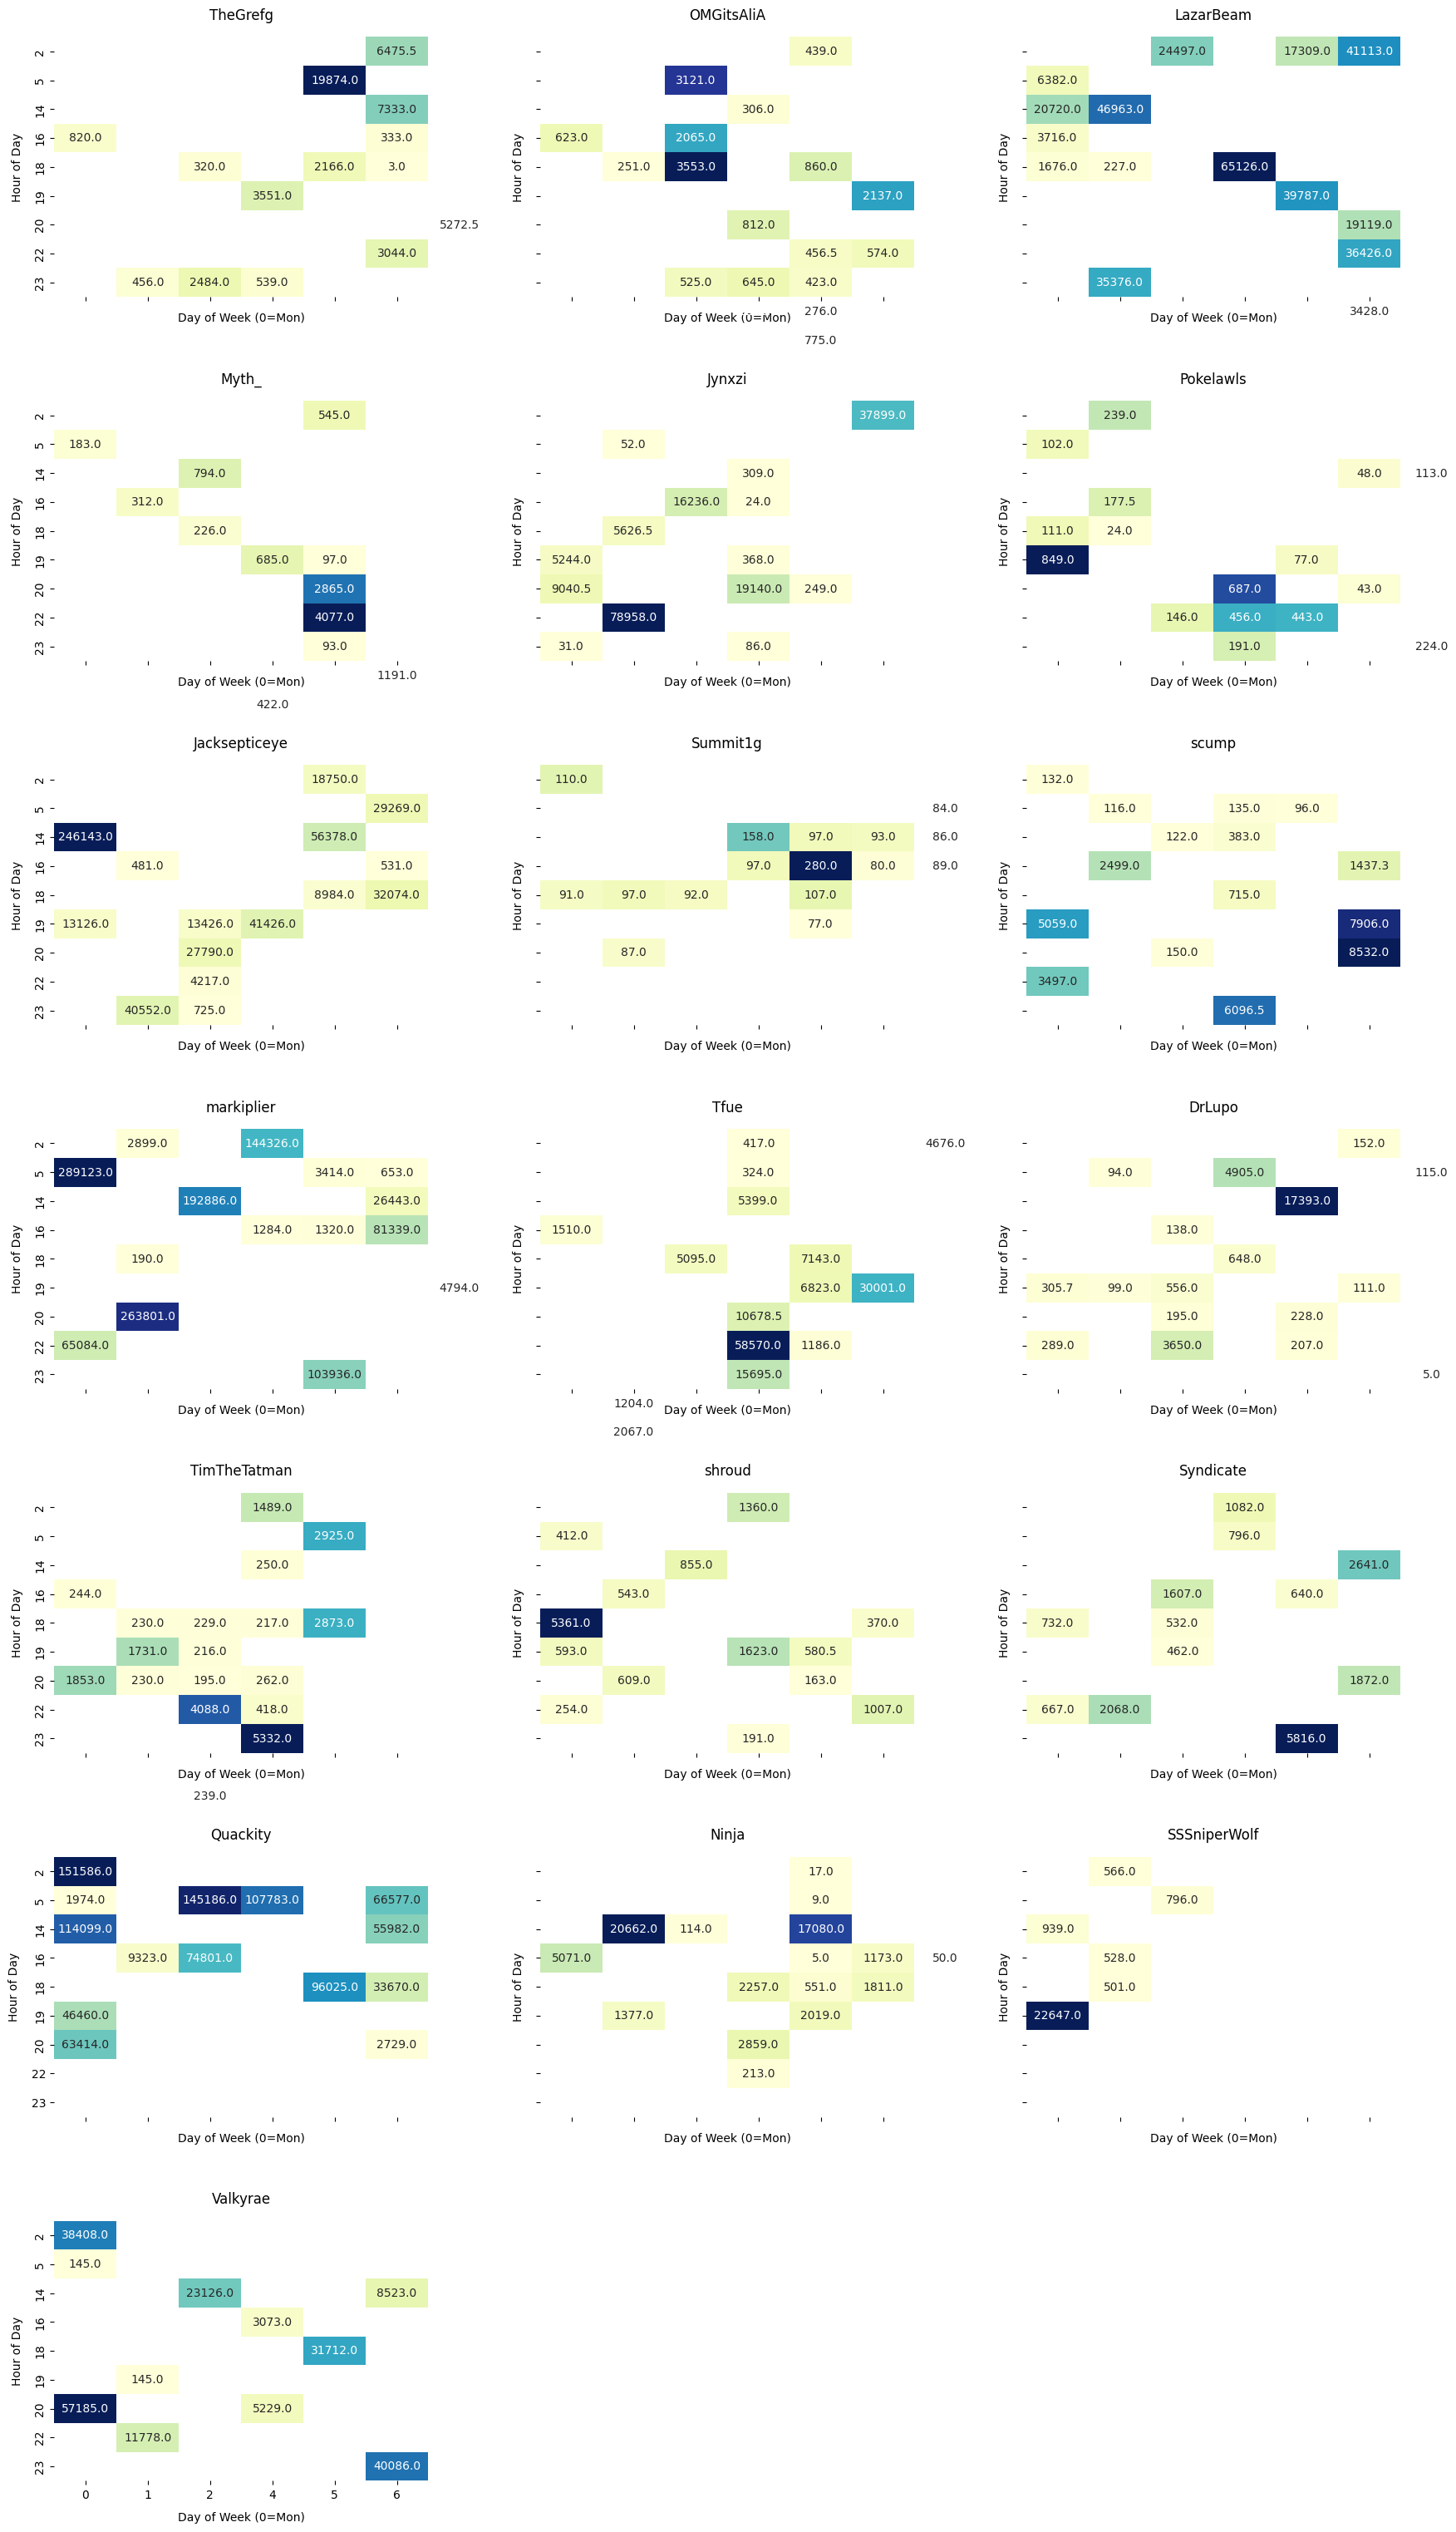

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

influencers = raw_df['username'].unique()
n = len(influencers)

cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), sharex=True, sharey=True)
axes = axes.flatten()

for i, influencer in enumerate(influencers):
    data = best_times[best_times['username'] == influencer]
    pivot = data.pivot(index='hour', columns='day_of_week', values='total_engagement')
    
    sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt=".1f", ax=axes[i], cbar=False)
    axes[i].set_title(f"{influencer}", pad=15)  # add space above title
    axes[i].set_ylabel("Hour of Day", labelpad=10)  # add space left of ylabel
    axes[i].set_xlabel("Day of Week (0=Mon)", labelpad=10)  # add space below xlabel

# Remove empty subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# Adjust spacing between plots and edges
fig.subplots_adjust(
    left=0.05,    # left margin
    right=0.95,   # right margin
    top=0.92,     # top margin
    bottom=0.08,  # bottom margin
    hspace=0.4,   # vertical space between subplots
    wspace=0.3    # horizontal space between subplots
)


# Save the figure before showing
output_path = "data/outputs/visualizations/heatmap_optimal_tweet_times.png"
fig.savefig(output_path, dpi=300)


plt.show()


## Sentiment Analysis

### Topic Modelling & Engagement

In [16]:
with open('data/raw/tweets_data.json', 'r') as f:
    tweets = json.load(f)

rows = []
for user in tweets:
    instructions = user.get('tweets', {}).get('result', {}).get('timeline', {}).get('instructions', [])
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            for entry in entries:
                content = entry.get('content', {})
                item_content = content.get('itemContent', {})
                tweet_result = item_content.get('tweet_results', {}).get('result', {})
                legacy = tweet_result.get('legacy', {})
                text = legacy.get('full_text', "")
                timestamp = legacy.get('created_at', None)
                if text and timestamp:
                    try:
                        dt = datetime.strptime(timestamp, '%a %b %d %H:%M:%S %z %Y')
                        rows.append({
                            'text': text,
                            'hour': dt.hour,
                            'likes': legacy.get('favorite_count', 0),
                            'retweets': legacy.get('retweet_count', 0)
                        })
                    except Exception as e:
                        print(f"Skipping tweet due to error: {e}")

df_tweets = pd.DataFrame(rows)
print(f"✅ Loaded {len(df_tweets)} tweets with timestamps.")

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_topics = vectorizer.fit_transform(df_tweets['text'])

✅ Loaded 308 tweets with timestamps.


<Figure size 1000x600 with 0 Axes>

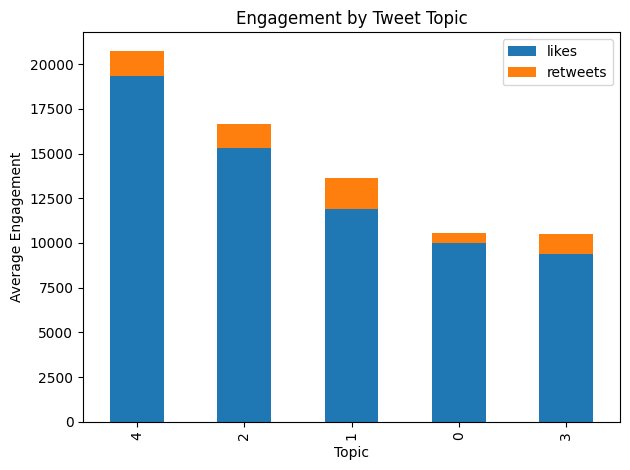


🗂 Top Keywords per Topic:
Topic 0: bxtd6meqh3, gta, chillin, rt, going, twitch, youtube, summit1g, live, https
Topic 1: optic, rt, night, stream, gonna, day, live, good, today, https
Topic 2: tomorrow, verdansk, work, safe, d7tqjildgj, fortnite, live, thank, rt, https
Topic 3: raiders, hwqufo0uxu, fortnite, love, live, day, en, time, rt, https
Topic 4: friend, 10, football, lt, running, live, ll, just, rt, https


In [17]:

# ---------------------------------------
# PART E: Topic Modeling & Engagement
# ---------------------------------------


lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_topics)

df_tweets['topic'] = lda.transform(X_topics).argmax(axis=1)
topic_engagement = df_tweets.groupby('topic')[['likes', 'retweets']].mean().sort_values(by='likes', ascending=False)

plt.figure(figsize=(10, 6))
topic_engagement.plot(kind='bar', stacked=True)
plt.title("Engagement by Tweet Topic")
plt.xlabel("Topic")
plt.ylabel("Average Engagement")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/engagement_by_topic.png", dpi=300)
plt.show()

print("\n🗂 Top Keywords per Topic:")
for idx, topic in enumerate(lda.components_):
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx}: {', '.join(top_keywords)}")

### Tweet Sentiment Distribution

/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_27823/2908435369.py:12: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_27823/2908435369.py:13: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig("data/outputs/visualizations/sentiment_distribution.png", dpi=300)
/Users/wenghong/anaconda3/envs/wif3009/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


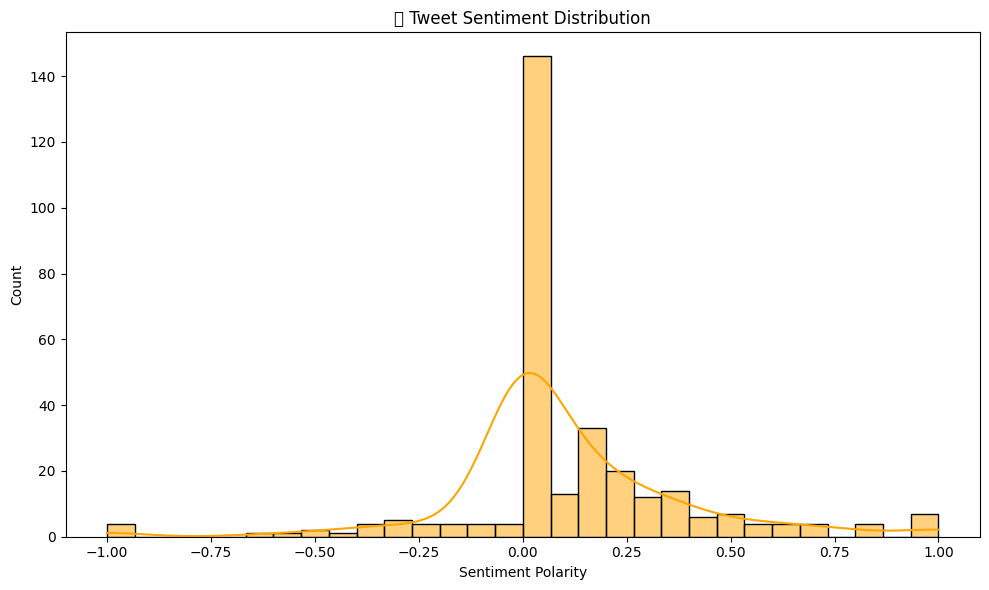

In [18]:
# ---------------------------------------
# PART D: Sentiment Analysis
# ---------------------------------------


df_tweets['sentiment'] = df_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.histplot(df_tweets['sentiment'], bins=30, kde=True, color='orange')
plt.title("🧠 Tweet Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/sentiment_distribution.png", dpi=300)
plt.show()

### Sentiment vs Engagement Correlation Heatmap

/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_27823/2279415229.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_27823/2279415229.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("data/outputs/visualizations/sentiment_engagement_correlation.png", dpi=300)
/Users/wenghong/anaconda3/envs/wif3009/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


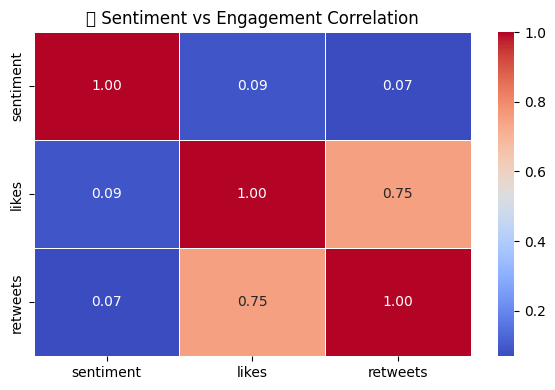

In [19]:
# Correlation matrix
sentiment_corr = df_tweets[['sentiment', 'likes', 'retweets']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(sentiment_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("📊 Sentiment vs Engagement Correlation")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/sentiment_engagement_correlation.png", dpi=300)
plt.show()


## Challenges & Future Work

**Challenges**
1. Incomplete or Noisy Data

- Many tweets were missing fields (e.g., full_text, engagement metrics), requiring data cleaning and imputation.

- JSON structures varied across accounts, increasing parsing complexity.

2. Temporal Sparsity

- Some influencers lacked consistent weekly activity, making rolling window features less reliable.

- Feature Correlation and Redundancy

- High correlation between features (e.g., retweets and likes) potentially introduced multicollinearity into models.

- Centrality Metrics Misalignment

- The network-based centrality scores didn’t always correlate well with actual tweet engagement due to external influence factors (e.g., trending topics, external promotions).

3. Sentiment Polarity Limitations

- Using TextBlob for sentiment analysis was simplistic and failed to capture sarcasm, emojis, or context-sensitive sentiment.

- Limited Explainability

**Future Work**
1. Incorporate Transformer-based NLP Models

- Replace TextBlob with more robust sentiment and semantic embeddings from models like BERT or RoBERTa for deeper tweet understanding.

2. Expand Social Graph Features

- Integrate dynamic social graphs and edge weights (e.g., frequency of mentions, retweets) to better reflect real-time influencer influence.


3. Real-time Prediction Dashboard

- Build a real-time dashboard that recommends optimal posting times and content themes per influencer using updated data streams.

- Community Detection Impact Study

- Explore how community membership within the social graph (e.g., from Louvain or Leiden algorithms) influences engagement patterns.

# Run Streamlit

In [ ]:
os.system("python -m streamlit run app.py ")


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.4:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
